In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns

sns.set_style("darkgrid")
import sys
import qss

### change this ###
sys.path.append("/Users/lukevolpatti/Documents/thesis/signal-decomposition/")
from gfosd import Problem
from gfosd.components import *

In [47]:
# Notebook-wide macros
SAVE = True

if SAVE:
    import matplotlib
    from matplotlib.backends.backend_pgf import FigureCanvasPgf

    matplotlib.backend_bases.register_backend("pdf", FigureCanvasPgf)
    sns.set_context("paper")
    matplotlib.rcParams["axes.unicode_minus"] = False
    # matplotlib.use("pgf")
    matplotlib.rcParams.update(
        {
            "pgf.texsystem": "pdflatex",
            "font.family": "serif",
            "text.usetex": True,
            "pgf.rcfonts": False,
        }
    )

# Data generation

In [68]:
T = int(1e4)
np.random.seed(42)
aa = T // 4
bb = T // 6
pwl = np.r_[
    np.linspace(0, 3, num=aa, endpoint=False),
    np.linspace(3, 1.5, num=bb, endpoint=False),
    np.linspace(1.5, -3, num=bb, endpoint=False),
    np.linspace(-3, -2.5, num=aa, endpoint=False),
    np.linspace(-2.5, 0, num=T - 2 * (aa + bb), endpoint=False),
]
noise = 0.2 * np.random.randn(T)
signal = pwl + noise
X_real = np.asarray([noise, pwl])
use_set = np.full(T, True)
use_set[: T // 5] = False
np.random.shuffle(use_set)
y = np.copy(signal)  # need signal for l1_tf
y[~use_set] = np.nan

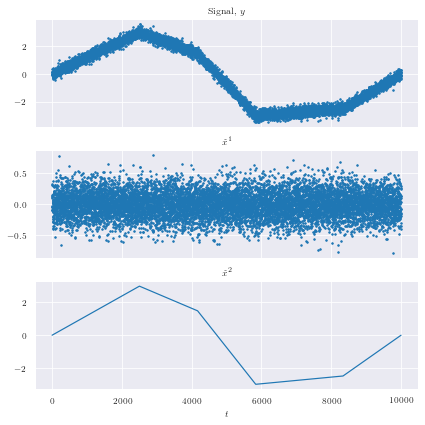

In [5]:
fig, ax = plt.subplots(
    nrows=3, sharex=True, figsize=(6, 6), rasterized=True
)  # (10, 8))
ax[0].scatter(np.arange(T), y, linewidth=0.9, s=2.5)
ax[1].scatter(np.arange(T), noise, linewidth=0.9, s=2.5)
ax[2].plot(pwl)
ax[0].set_title("Signal, $y$")
for i in range(X_real.shape[0]):
    ax[i + 1].set_title("$\\tilde{x}^{" + "{}".format(i + 1) + "}$")
ax[-1].set_xlabel("$t$")
plt.tight_layout()
if SAVE:
    plt.gcf().savefig("./l1-trend-data.pgf", dpi=250)

# Problem solution

## Signal decomposition via QSS

In [35]:
component1 = SumSquare(weight=1 / len(y))
component2 = SumAbs(weight=1, diff=2)
prob = Problem(y, [component1, component2])
prob.decompose(verbose=True, precond=False, eps_abs=1e-5, eps_rel=1e-5)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      3.51e-02s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 9.86e-01    5.63e+01     1.89e+01   [0.1 0.1]  3.12e-03
   25 | 5.25e-01    1.34e+00     1.67e-01   [0.1 0.1]  3.90e-02
   50 | 8.81e-02    5.80e+01     8.87e+01   [1.e+06 1.e-06]  8.69e-02
   75 | 2.39e-02    8.85e-03     2.68e+00   [1.e+06 1.e-06]  1.23e-01
  100 | 1.71e+00    1.43e+01     3.34e-02   [3.06694636e-01 1.00000000e-06]  1.71e-01
  125 | 1.01e-01    4.50e-02     2.63e-04   [3.06694636e-01 1.00000000e-06]  2.19e-01
  15

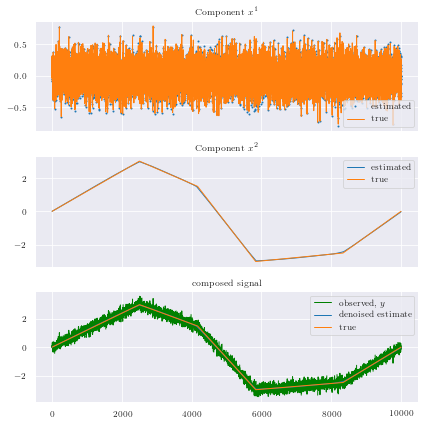

In [53]:
X_real = np.vstack([noise, pwl])
fig = prob.plot_decomposition(X_real=X_real, figsize=(6, 6), rasterized=True)
plt.tight_layout()
plt.show()
if SAVE:
    fig.savefig("./l1-trend-qss.pgf", dpi=250)

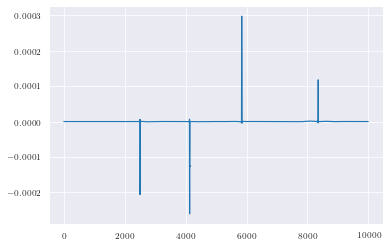

In [45]:
qss_res = prob.decomposition[1]
plt.plot(np.diff(qss_res, n=2))
if SAVE:
    plt.savefig("l1-trend-qss-second-diff.pgf")

## Signal decomposition via OSQP

In [58]:
prob.decompose(verbose=True, solver="OSQP")

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Aug 17 01:30:19 PM: Your problem has 29998 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 17 01:30:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 17 01:30:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 17 01:30:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 17 01:30:19 PM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 17 01:30:19 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

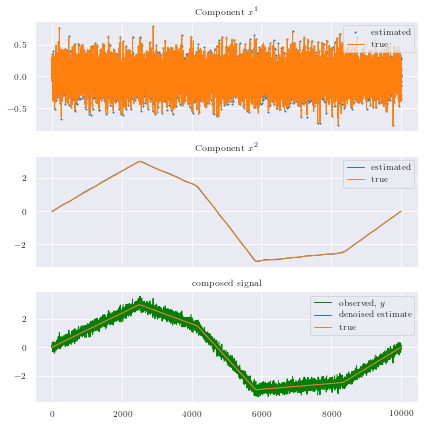

In [59]:
X_real = np.vstack([noise, pwl])
fig = prob.plot_decomposition(X_real=X_real, figsize=(6, 6), rasterized=True)
plt.tight_layout()
plt.show()
if SAVE:
    fig.savefig("./l1-trend-osqp.pgf", dpi=250)

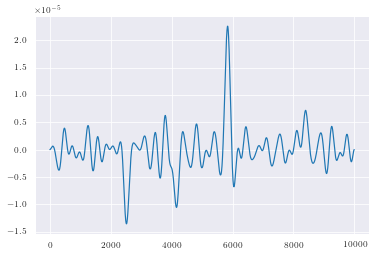

In [61]:
res = prob.decomposition[1]
plt.plot(np.diff(res, n=2))
if SAVE:
    plt.savefig("l1-trend-osqp-second-diff.pgf")

# Signal decomposition via masked proximal operators

In [98]:
from osd import Problem
from osd.classes import MeanSquareSmall, SparseSecondDiffConvex

component1 = MeanSquareSmall(size=len(y), weight=1 / len(y))
component2 = SparseSecondDiffConvex(weight=1, solver="MOSEK")
prob = Problem(y, [component1, component2])
prob.decompose(verbose=True)

Convex problem detected. Using BCD...
Starting BCD...
y shape: (10000,)
X shape: (2, 10000)

[====================] ...2 iterations, 1.09 sec -- obj_val: 8.00e-03, r: 3.12e-19, tol: 1.00e-05      



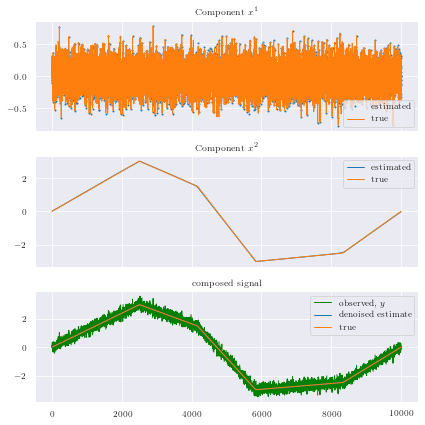

In [101]:
fig = prob.plot_decomposition(X_real=X_real, figsize=(6, 6), rasterized=True)
plt.legend()
if SAVE:
    fig.savefig("./l1-trend-osdv1.pgf", dpi=250)

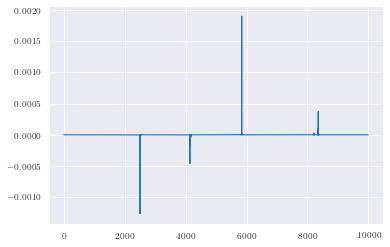

In [102]:
res = prob.components[1]
plt.plot(np.diff(res, n=2))
if SAVE:
    plt.savefig("l1-trend-osdv1-second-diff.pgf")

# l1_tf

In [95]:
import subprocess
import time

In [97]:
np.savetxt("signal.txt", signal, fmt="%f")
subprocess.call("make ./l1_tf/", shell=True)
start = time.time()
subprocess.call("./l1_tf/l1tf signal.txt " + str(T) + " > l1_tfres.txt", shell=True)
print(time.time() - start)
res = np.loadtxt("l1_tfres.txt")

make: Nothing to be done for `l1_tf/'.
0.059155941009521484


--------------------------------------------
l1 trend filtering via primal-dual algorithm
C version 0.7 Aug 18 2007                   
Kwangmoo Koh, Seung-Jean Kim, Stephen Boyd
--------------------------------------------
data length         = 10000
lambda (lambda_max) = 1.000000e+04 (4.238749e+06)

Iteration   Primal obj.    Dual obj.      Gap
     0      3.9560e+07   0.00000e+00   3.96e+07
     1      2.1884e+04   1.95536e+02   2.17e+04
     2      4.2196e+03   1.97982e+02   4.02e+03
     3      5.9881e+02   2.00876e+02   3.98e+02
     4      3.2879e+02   2.09999e+02   1.19e+02
     5      2.9807e+02   2.33803e+02   6.43e+01
     6      2.9352e+02   2.66277e+02   2.72e+01
     7      2.8982e+02   2.73121e+02   1.67e+01
     8      2.8705e+02   2.76792e+02   1.03e+01
     9      2.8522e+02   2.78663e+02   6.56e+00
    10      2.8394e+02   2.79685e+02   4.25e+00
    11      2.8304e+02   2.80285e+02   2.76e+00
    12      2.8243e+02   2.80657e+02   1.77e+00
    13      2.8222e+02   2.8

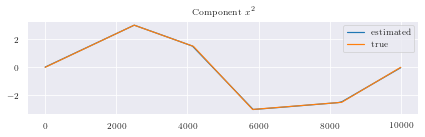

In [96]:
plt.figure(figsize=(6, 2))
plt.plot(res, label="estimated")
plt.plot(pwl, label="true")
plt.title("Component $x^2$")
plt.legend()
plt.tight_layout()
fig = plt.gcf()
plt.show()
if SAVE:
    fig.savefig("./l1-trend-l1tf.pgf")

In [92]:
m1 = sp.sparse.eye(m=T - 2, n=T, k=0)
m2 = sp.sparse.eye(m=T - 2, n=T, k=1)
m3 = sp.sparse.eye(m=T - 2, n=T, k=2)
D = m1 - 2 * m2 + m3

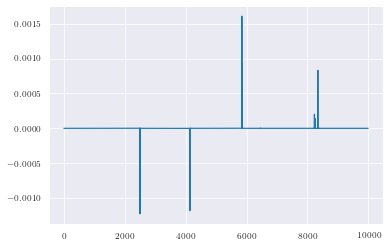

In [93]:
plt.plot(np.diff(res, n=2))
if SAVE:
    plt.savefig("l1-trend-l1tf-second-diff.pgf")